In [1]:
library(ropls)
library(ggplot2)
library(ggsci)
library(Cairo)
library(tidyverse)
library(extrafont)
loadfonts()

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘ggsci’ was built under R version 4.2.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tibble::view()  mask

In [13]:
load('./oplas.Rdata')

In [15]:
head(expr_mat)

,Intensity_1,Intensity_2
,<dbl>,<dbl>
4CL3,0,29381000
ACC1,0,45058000
ACC2,3196600,98347000
ACLA-1,0,40757000
ACLA-2,0,40757000
ACLB-1,2810100,182190000


In [16]:
head(group_info)

,sample,group
,<chr>,<chr>
1,Intensity_1,Intensity1
2,Intensity_2,Intensity2


In [26]:
sacurine.plsda <- opls(t(expr_mat), group_info$sample)

ERROR: Error: 'crossvalI' must be less than the row number of 'x'


In [2]:
dataMatrix = read.csv('./metabolomics_data.csv',row.names = 1)

In [3]:
 dataMatrix = dataMatrix %>% dplyr::select(contains('CLP'))

In [4]:
dataMatrix= t(dataMatrix)

In [5]:
sampleMetadata = read.table('./sample.txt',sep = '\t',header =T,row.names = 1)

In [6]:
sampleMetadata$gender = rep(c('KO-CLP','WT-CLP'),each = 8)

In [7]:
variableMetadata = read.csv('./variable.csv',header =T,row.names = 1,check.names = F)

PCA
16 samples x 1319 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.543   3   0


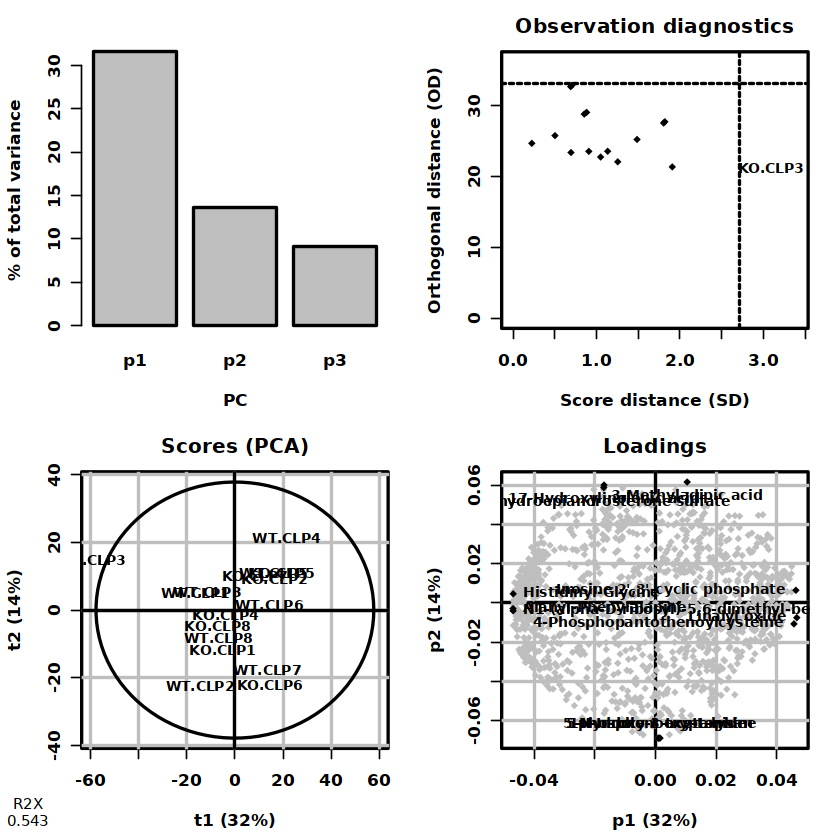

In [8]:
pca = opls(dataMatrix)
genderFc = sampleMetadata[, "group"]

PCA
16 samples x 1319 variables
standard scaling of predictors
      R2X(cum) pre ort
Total    0.543   3   0


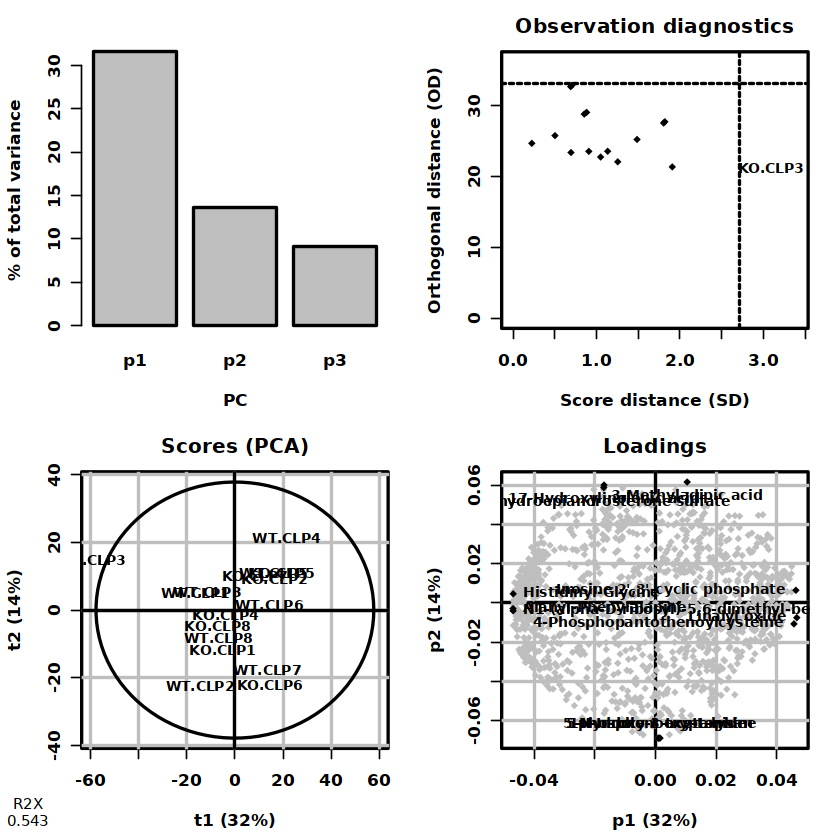

In [9]:
pca = opls(dataMatrix)
groupFc = factor(sampleMetadata[,'group'],levels = c('KO-CLP','WT-CLP'))

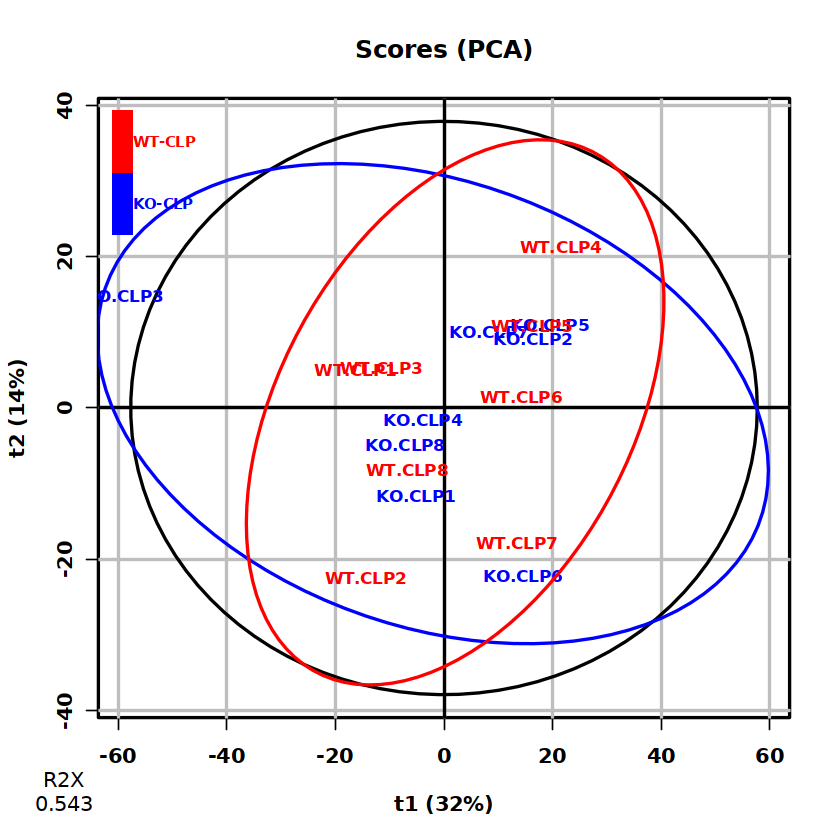

In [10]:
plot(pca, typeVc = "x-score",
     parAsColFcVn = groupFc, parEllipsesL = TRUE)

PLS-DA
16 samples x 1319 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum) RMSEE pre ort pR2Y  pQ2
Total    0.397    0.933   0.557 0.144   2   0 0.05 0.05


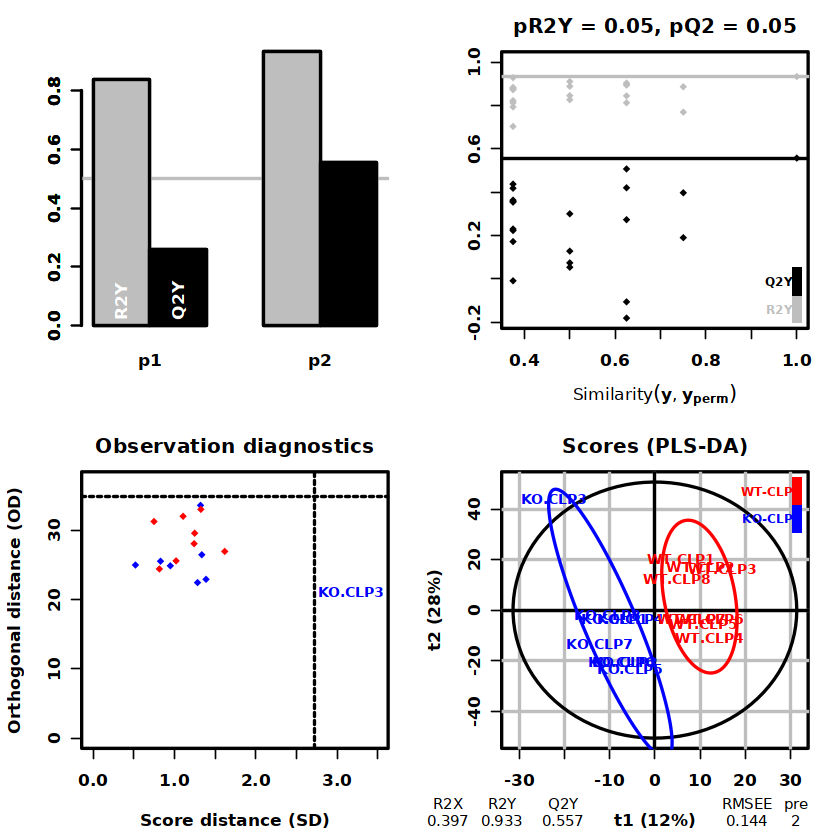

In [11]:
sacurine.plsda <- opls(dataMatrix, groupFc, predI = 2)

In [15]:
sample.score = sacurine.plsda@scoreMN %>% 
  as.data.frame() %>%
  mutate(group = groupFc)

In [16]:
p1 = ggplot(sample.score, aes(p1, p2, color = group)) +
  geom_hline(yintercept = 0, linetype = 'dashed', size = 0.5) +
  geom_vline(xintercept = 0, linetype = 'dashed', size = 0.5) +
  geom_point() +
  geom_point(aes(-10,-10), color = 'white') +
  labs(x = 'P1(10.0%)',y = 'P2(9%)') +
  stat_ellipse(level = 0.95, linetype = 'solid', 
               size = 1, show.legend = FALSE) +
  #scale_color_manual(values = c('#008000','#FFA74F')) +
  theme_bw() +
  theme(legend.position = c(0.9,0.8),
    legend.text = element_text(color = 'black',size = 12, family = 'Arial', face = 'plain'),
    panel.background = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
    axis.title = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
    axis.ticks = element_line(color = 'black'))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


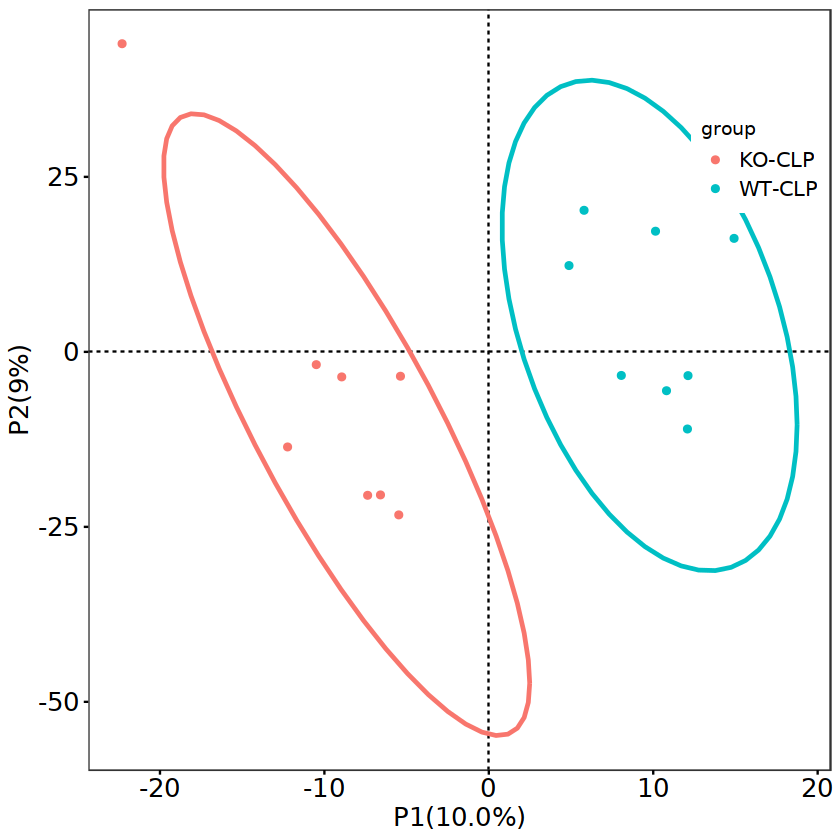

In [40]:
p1

In [17]:
vip.score = as.data.frame(sacurine.plsda@vipVn)
colnames(vip.score) = 'vip'
vip.score$metabolites = rownames(vip.score)
vip.score = vip.score[order(-vip.score$vip),]
vip.score$metabolites = factor(vip.score$metabolites,
                               levels = vip.score$metabolites)

In [18]:

loading.score = sacurine.plsda@loadingMN %>% as.data.frame()
loading.score$metabolites = rownames(loading.score)
 
all.score = merge(vip.score, loading.score, by = 'metabolites')
 
all.score$cat = paste('A',1:nrow(all.score), sep = '')

In [19]:

p2 = ggplot(all.score[all.score$vip >= 1,], aes(cat, vip)) +
  geom_segment(aes(x = cat, xend = cat,
                   y = 0, yend = vip)) +
  geom_point(shape = 21, size = 5, color = '#008000' ,fill = '#008000') +
  geom_point(aes(1,2.5), color = 'white') +
  geom_hline(yintercept = 1, linetype = 'dashed') +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = '', y = 'VIP value') +
  theme_bw() +
  theme(legend.position = 'none',
        legend.text = element_text(color = 'black',size = 12, family = 'Arial', face = 'plain'),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.text = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.ticks = element_line(color = 'black'),
        axis.ticks.x = element_blank())


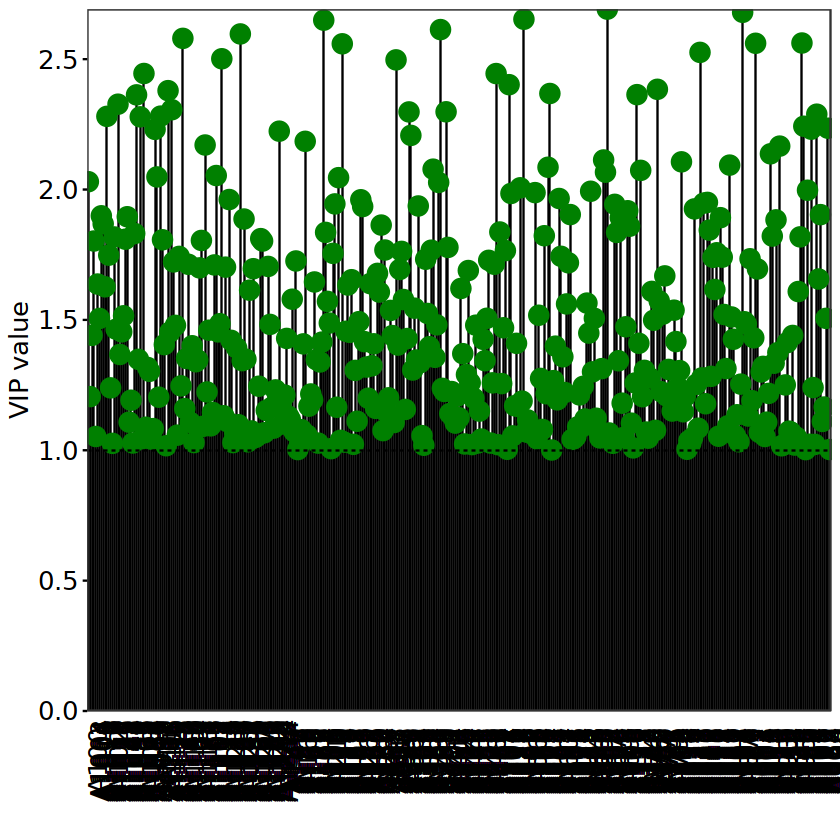

In [44]:
p2

In [20]:
Sys.setlocale('LC_ALL','C')

[1] "LC_CTYPE=C;LC_NUMERIC=C;LC_TIME=C;LC_COLLATE=C;LC_MONETARY=C;LC_MESSAGES=en_US.UTF-8;LC_PAPER=en_US.UTF-8;LC_NAME=C;LC_ADDRESS=C;LC_TELEPHONE=C;LC_MEASUREMENT=en_US.UTF-8;LC_IDENTIFICATION=C"

In [21]:
aa = cbind(as.data.frame(all.score$metabolites),all.score$vip)

In [22]:
colnames(aa) = c('metabolites','vip')

In [23]:
aa = aa %>% filter(vip >1)

In [51]:
write.csv(aa,file = 'vip.csv',row.names =F)

### OPLS-DA分析

Warning message:
"OPLS: number of predictive components ('predI' argument) set to 1"


OPLS-DA
16 samples x 1319 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.451    0.994   0.561 0.0456   1   2 0.05 0.05


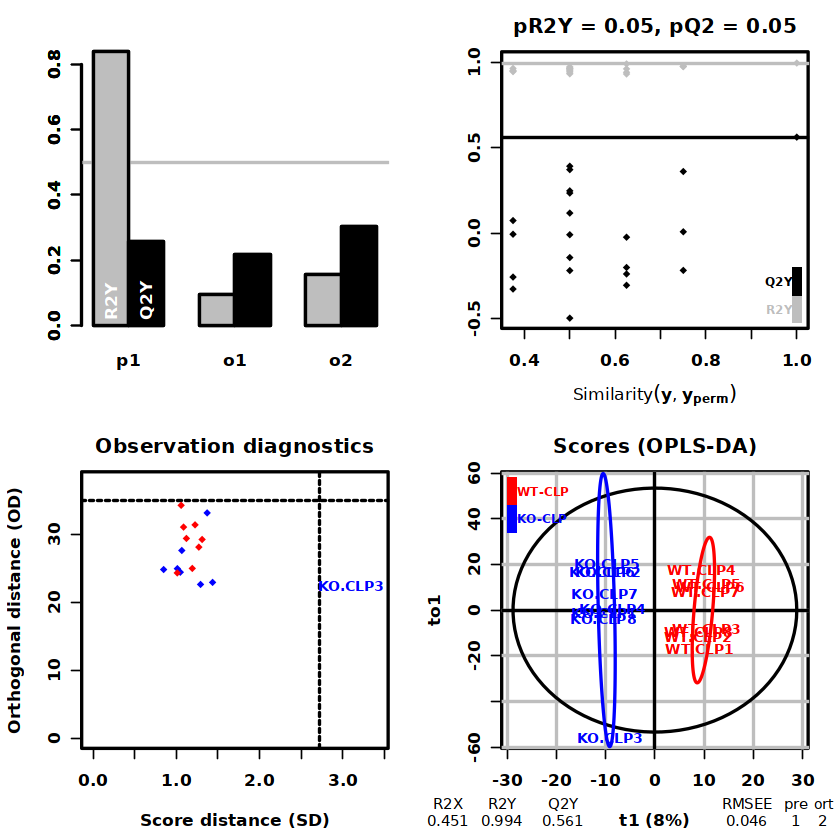

In [24]:
oplsda = opls(dataMatrix, genderFc, predI = 3,orthoI = NA)

In [25]:
sample.score = oplsda@scoreMN %>% 
  as.data.frame() %>%
   mutate(group = groupFc)

In [26]:
vip.score = as.data.frame(oplsda@vipVn)
colnames(vip.score) = 'vip'
vip.score$metabolites = rownames(vip.score)
vip.score = vip.score[order(-vip.score$vip),]
vip.score$metabolites = factor(vip.score$metabolites,
                               levels = vip.score$metabolites)
 
loading.score = oplsda@loadingMN %>% as.data.frame()
loading.score$metabolites = rownames(loading.score)
 
all.score = merge(vip.score, loading.score, by = 'metabolites')
 
all.score$cat = paste('A',1:nrow(all.score), sep = '')

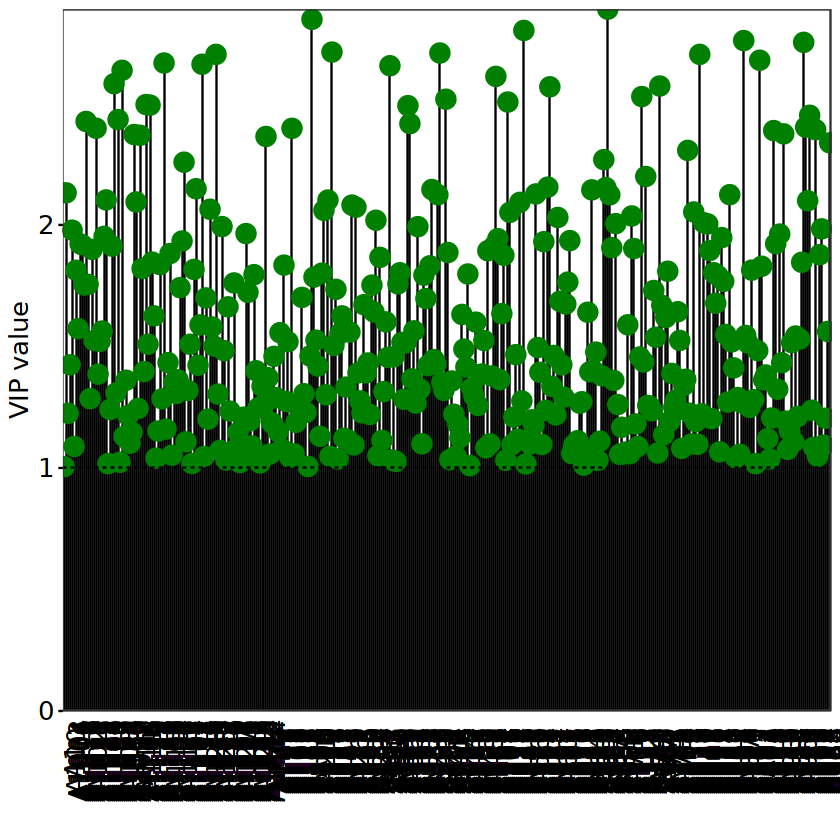

In [67]:
p4 = ggplot(all.score[all.score$vip >= 1,], aes(cat, vip)) +
  geom_segment(aes(x = cat, xend = cat,
                   y = 0, yend = vip)) +
  geom_point(shape = 21, size = 5, color = '#008000' ,fill = '#008000') +
  geom_point(aes(1,2.5), color = 'white') +
  geom_hline(yintercept = 1, linetype = 'dashed') +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = '', y = 'VIP value') +
  theme_bw() +
  theme(legend.position = 'none',
        legend.text = element_text(color = 'black',size = 12, family = 'Arial', face = 'plain'),
        panel.background = element_blank(),
        panel.grid = element_blank(),
        axis.text = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(color = 'black',size = 15, family = 'Arial', face = 'plain'),
        axis.ticks = element_line(color = 'black'),
        axis.ticks.x = element_blank())
p4

In [27]:

all.score = all.score %>% filter(vip > 1.5)

In [28]:
aa = read.csv('./vip.csv')

In [29]:
length(intersect(all.score$metabolites,aa$metabolites))

[1] 175

In [97]:
write.csv(all.score,file = 'oplsda-vip1.5.csv',row.names =F)

In [30]:
df = dataMatrix %>% as.data.frame()
df$gender = groupFc
df = df[order(df$gender),]

In [31]:
df = df[,-1320]

In [32]:
M.mean = apply(df[1:8,],2,FUN = mean)
F.mean = apply(df[9:16,],2,FUN = mean)

In [33]:
FC = M.mean / F.mean
log2FC = log(FC,2)

In [34]:
pvalue = apply(df, 2, function(x)
  {t.test(x[1:8],x[9:16])$p.value})

In [35]:
p.adj = p.adjust(pvalue, method = 'BH')
p.adj.log = -log10(p.adj)
 
colcano.df = data.frame(log2FC,p.adj,pvalue, p.adj.log)
colcano.df$cat = ifelse(colcano.df$log2FC >= 1 & colcano.df$pvalue < 0.05,'Up',
                        ifelse(colcano.df$log2FC <= -1 & colcano.df$pvalue < 0.05,'Down','NS'))


In [36]:
table(colcano.df$cat )


Down   NS   Up 
  37 1276    6 

In [68]:
pathway = read.csv('/data/workdirV6/KEGG_COMPOUND_PATHWAY_mmu.csv')

In [69]:
pathway = pathway[,c(2,7)]

In [63]:
colnames(pathway) = c('term','gene')

In [64]:
data_all_sort <- colcano.df %>%
 arrange(desc(log2FC))

In [65]:
geneList = data_all_sort$log2FC 
names(geneList) <- rownames(data_all_sort)
head(geneList)

Leucyl-Glutamine      Histidinyl-Tryptophan 
                  4.045286                   2.694875 
4-Hydroxycinnamoylagmatine         Tryptophyl-Glycine 
                  2.576115                   2.262017 
         Alanyl-Isoleucine             Glutamylvaline 
                  2.047485                   2.000352

In [66]:
data_all_sort

,log2FC,p.adj,pvalue,p.adj.log,cat
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Leucyl-Glutamine,4.045286,0.9336034,0.22221056,0.02983757,NS
Histidinyl-Tryptophan,2.694875,0.9336034,0.40175549,0.02983757,NS
4-Hydroxycinnamoylagmatine,2.576115,0.8892745,0.14899898,0.05096417,NS
Tryptophyl-Glycine,2.262017,0.9336034,0.29726946,0.02983757,NS
Alanyl-Isoleucine,2.047485,0.9336034,0.27241164,0.02983757,NS
Glutamylvaline,2.000352,0.9336034,0.32532369,0.02983757,NS
Glycylleucine,1.980746,0.9336034,0.33813736,0.02983757,NS
Glycyl-Tryptophan,1.910928,0.9336034,0.35568061,0.02983757,NS
Cinnamoylglycine,1.900464,0.9336034,0.34074258,0.02983757,NS


In [2]:
library(tidyverse)
library(data.table)
library(org.Hs.eg.db)
library(clusterProfiler)
library(biomaRt)
library(enrichplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.3     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘data.table’ was built under R version 4.2.3”

A

In [53]:
gsea <- GSEA(geneList,
            TERM2GENE = pathway,
            pvalueCutoff = 1,minGSSize = 10,maxGSSize = 500,eps =0) 

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



In [54]:
gsea@result

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ABC transporters - Mus musculus (house mouse),ABC transporters - Mus musculus (house mouse),ABC transporters - Mus musculus (house mouse),36,-0.6556708,-1.7742937,0.02656174,0.2390556,0.2236778,137,"tags=36%, list=10%, signal=33%",Deoxyuridine/L-Valine/Adenosine/Inosine/Uridine/Guanosine/Deoxyadenosine/Deoxycytidine/L-Phenylalanine/Deoxyinosine/Xylobiose/Deoxyguanosine/Biotin
Purine metabolism - Mus musculus (house mouse),Purine metabolism - Mus musculus (house mouse),Purine metabolism - Mus musculus (house mouse),15,-0.7744363,-1.7527223,0.02348837,0.2390556,0.2236778,236,"tags=67%, list=18%, signal=55%",Adenosine/Xanthine/Inosine/IDP/Guanosine/Hypoxanthine/Deoxyadenosine/Acetyl adenylate/Deoxyinosine/Deoxyguanosine
Metabolism of xenobiotics by cytochrome P450 - Mus musculus (house mouse),Metabolism of xenobiotics by cytochrome P450 - Mus musculus (house mouse),Metabolism of xenobiotics by cytochrome P450 - Mus musculus (house mouse),21,-0.5900186,-1.4590679,0.06990291,0.4194175,0.3924374,91,"tags=33%, list=7%, signal=32%","S-(Formylmethyl)glutathione/1-Nitro-5-hydroxy-6-glutathionyl-5,6-dihydronaphthalene/1-Nitro-5-glutathionyl-6-hydroxy-5,6-dihydronaphthalene/1-Naphthol/S-(2-Hydroxyethyl)glutathione/Naphthalene-1,2-diol/Glutathione episulfonium ion"
Aminoacyl-tRNA biosynthesis - Mus musculus (house mouse),Aminoacyl-tRNA biosynthesis - Mus musculus (house mouse),Aminoacyl-tRNA biosynthesis - Mus musculus (house mouse),15,-0.5942655,-1.3449555,0.13600000,0.4561404,0.4267980,475,"tags=67%, list=36%, signal=43%",L-Glutamine/L-Serine/L-Proline/L-Lysine/L-Threonine/L-Tryptophan/L-Histidine/L-Tyrosine/L-Valine/L-Phenylalanine
Arginine and proline metabolism - Mus musculus (house mouse),Arginine and proline metabolism - Mus musculus (house mouse),Arginine and proline metabolism - Mus musculus (house mouse),11,-0.6135538,-1.3013758,0.14843750,0.4561404,0.4267980,59,"tags=55%, list=4%, signal=53%",L-Proline/N-Methylhydantoin/N-Carbamoylsarcosine/Creatine/Spermine/Agmatine
Central carbon metabolism in cancer - Mus musculus (house mouse),Central carbon metabolism in cancer - Mus musculus (house mouse),Central carbon metabolism in cancer - Mus musculus (house mouse),13,-0.5744225,-1.2672631,0.18058252,0.4561404,0.4267980,308,"tags=69%, list=23%, signal=54%",L-Alanine/L-Glutamine/L-Serine/L-Proline/L-Tryptophan/L-Histidine/L-Tyrosine/L-Valine/L-Phenylalanine
Protein digestion and absorption - Mus musculus (house mouse),Protein digestion and absorption - Mus musculus (house mouse),Protein digestion and absorption - Mus musculus (house mouse),18,-0.5343234,-1.2662031,0.16302187,0.4561404,0.4267980,441,"tags=67%, list=33%, signal=45%",L-Glutamine/L-Serine/L-Proline/L-Lysine/L-Threonine/Tyramine/beta-Alanine/L-Tryptophan/L-Histidine/L-Tyrosine/L-Valine/L-Phenylalanine
Mineral absorption - Mus musculus (house mouse),Mineral absorption - Mus musculus (house mouse),Mineral absorption - Mus musculus (house mouse),12,-0.5755658,-1.2426874,0.20272904,0.4561404,0.4267980,475,"tags=83%, list=36%, signal=54%",D-Glucose/L-Alanine/L-Glutamine/L-Serine/L-Proline/D-Galactose/L-Threonine/L-Tryptophan/L-Valine/L-Phenylalanine
D-Amino acid metabolism - Mus musculus (house mouse),D-Amino acid metabolism - Mus musculus (house mouse),D-Amino acid metabolism - Mus musculus (house mouse),12,-0.4951037,-1.0689640,0.35672515,0.7134503,0.6675558,475,"tags=67%, list=36%, signal=43%",L-Alanine/L-Glutamine/L-Serine/L-Proline/L-Lysine/L-Threonine/L-Histidine/L-Phenylalanine


In [143]:
options(repr.plot.height = 6,repr.plot.width = 10)

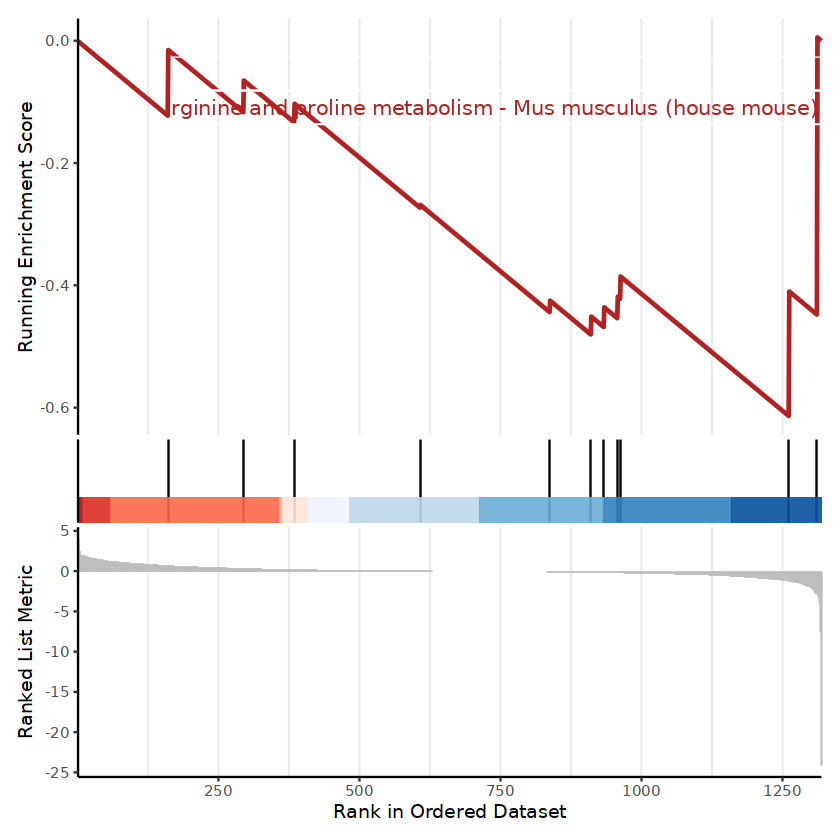

In [73]:
gseaplot2(gsea, "Arginine and proline metabolism - Mus musculus (house mouse)", color = "firebrick",  pvalue_table = TRUE,rel_heights=c(1, .2, .6))

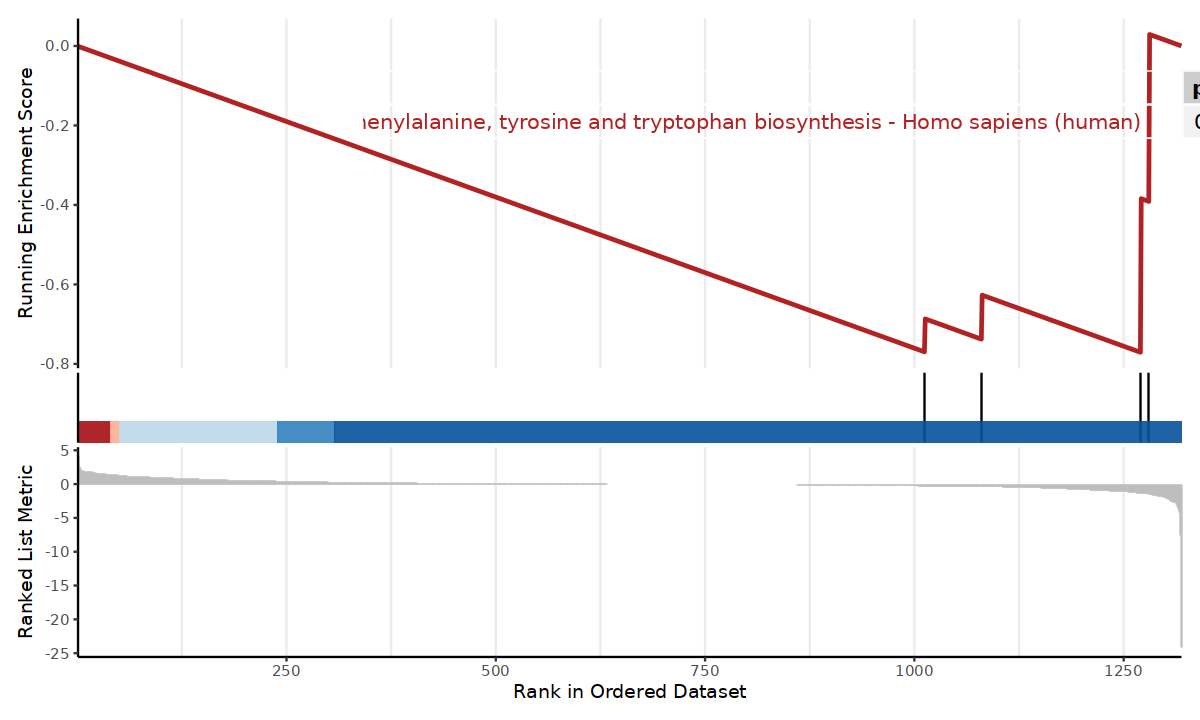

In [147]:
gseaplot2(gsea, "Phenylalanine, tyrosine and tryptophan biosynthesis - Homo sapiens (human)", color = "firebrick",  pvalue_table = TRUE,rel_heights=c(1, .2, .6))

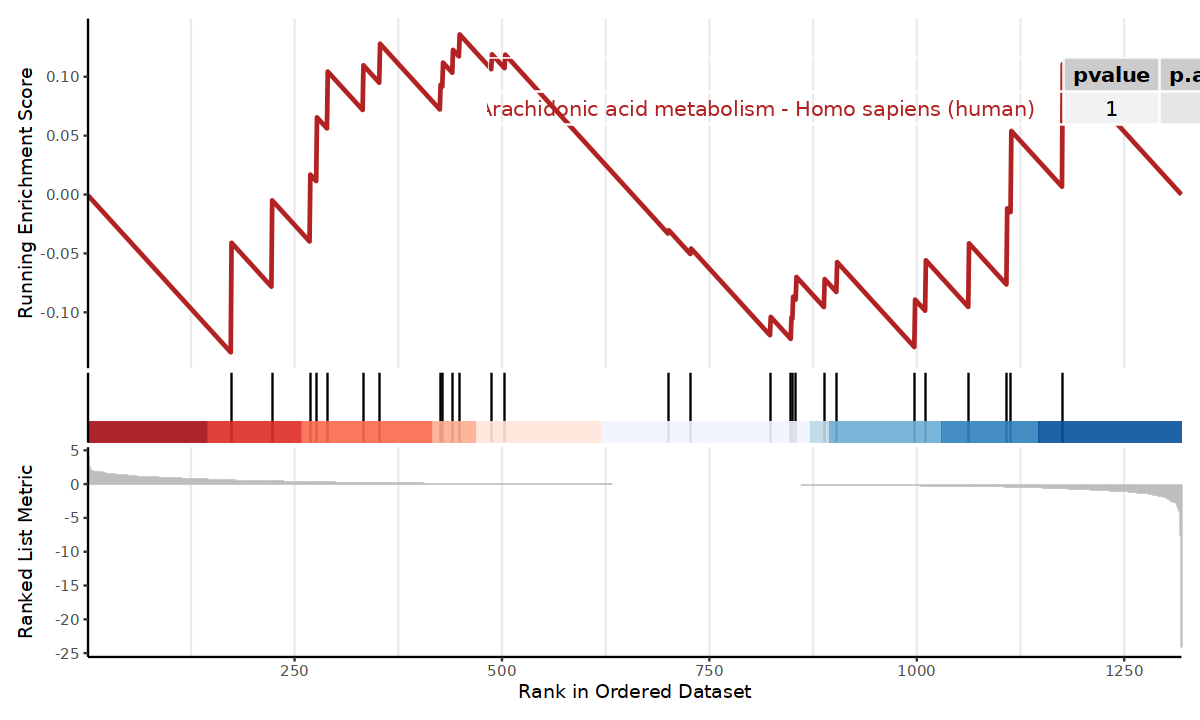

In [148]:
gseaplot2(gsea, "Arachidonic acid metabolism - Homo sapiens (human)", color = "firebrick",  pvalue_table = TRUE,rel_heights=c(1, .2, .6))

In [150]:
write.csv(gsea@result,file = 'gsea_metabolite.csv',row.names =F)

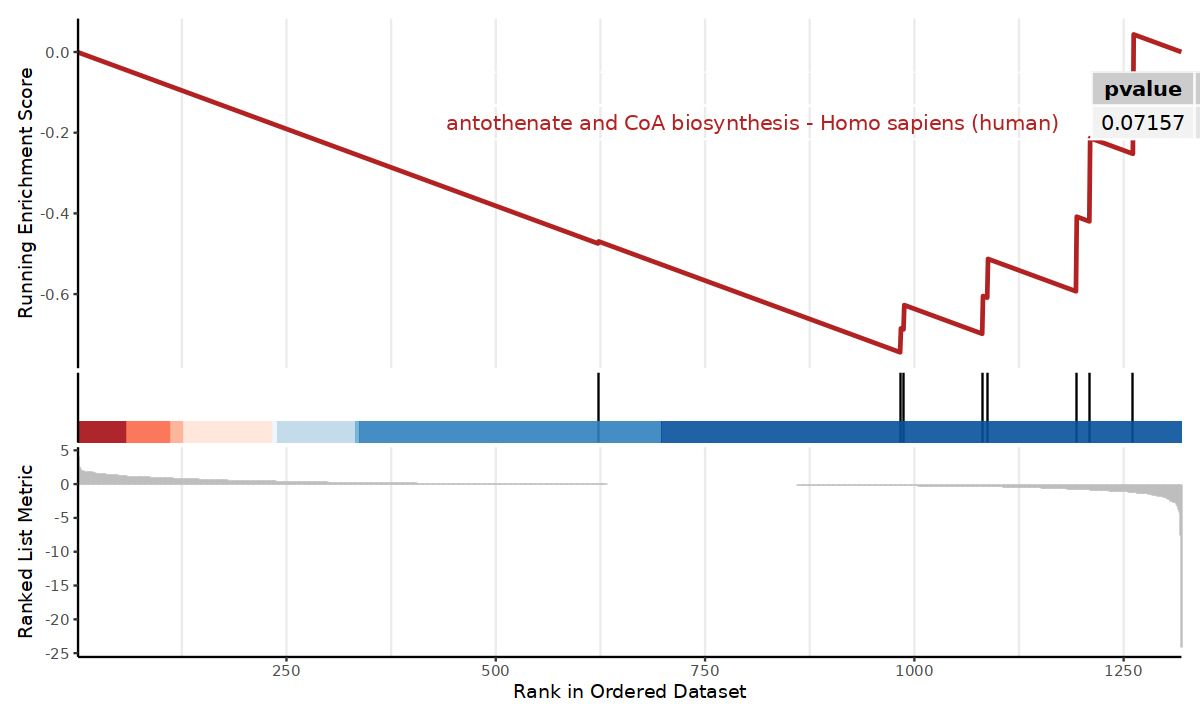

In [153]:
gseaplot2(gsea, "Pantothenate and CoA biosynthesis - Homo sapiens (human)", color = "firebrick",  pvalue_table = TRUE,rel_heights=c(1, .2, .6))